In [ ]:
import openai
import pandas as pd
import json
import time
import re
from tqdm import tqdm
from statistics import mean
import random

# --- OpenAI Setup ---
openai.api_key = "sk-proj--" 
MODEL_NAME = "gpt-4o-mini"

# --- File Paths ---
INPUT_CSV = "Final_results.csv"
OUTPUT_FILE = "llm_eval_results_urdu.csv"
SUMMARY_FILE = "llm_eval_summary_urdu.csv"

# --- Sample Size for Cost Control ---
SAMPLE_SIZE = 120  # out of 900
df = pd.read_csv(INPUT_CSV)
df_sample = df.sample(n=SAMPLE_SIZE, random_state=42).reset_index(drop=True)

# --- Prompt Builder ---
def build_prompt(query, gt_context, gt_answer, sys_name, retrieved_context, generated_answer):
    return f"""
آپ ایک ماہر تجزیہ کار ہیں جو اردو سوال و جواب کے نظاموں کا تجزیہ کرتے ہیں۔

آپ کو درج ذیل معلومات دی گئی ہیں:
- صارف کا سوال
- اصل (گراؤنڈ ٹروتھ) سیاق و سباق اور جواب
- کسی ایک RAG سسٹم کا حاصل کردہ سیاق و سباق اور تیار کردہ جواب

ہر نظام کے جواب کو درج ذیل معیار پر 0 سے 5 تک درجہ دیں:
1. Faithfulness (سچائی): جواب کس حد تک فراہم کردہ سیاق و سباق پر مبنی ہے۔
2. Answer Correctness (درستی): جواب کس حد تک اصل جواب سے ہم معنی ہے۔
3. Context Relevance (موزونیت): سیاق و سباق سوال سے کتنا متعلق ہے۔
4. Conciseness/Completeness (اختصار و تکمیل): جواب مختصر مگر مکمل ہے یا نہیں۔

جواب صرف درج ذیل JSON فارمیٹ میں دیں:
{{
  "faithfulness": 0-5,
  "answer_correctness": 0-5,
  "context_relevance": 0-5,
  "conciseness_completeness": 0-5,
  "short_reason": "مختصر تجزیہ اردو یا انگریزی میں"
}}

---

سوال:
{query}

گراؤنڈ ٹروتھ سیاق:
{gt_context}

گراؤنڈ ٹروتھ جواب:
{gt_answer}

({sys_name}) کا حاصل کردہ سیاق:
{retrieved_context}

({sys_name}) کا تیار کردہ جواب:
{generated_answer}
"""

# --- Clean JSON if LLM outputs extra text ---
def clean_json(raw_text):
    match = re.search(r"\{.*\}", raw_text, re.DOTALL)
    if match:
        try:
            return json.loads(match.group())
        except:
            pass
    return {
        "faithfulness": 0,
        "answer_correctness": 0,
        "context_relevance": 0,
        "conciseness_completeness": 0,
        "short_reason": "Failed to parse JSON"
    }

# --- OpenAI Evaluation with retry ---
def evaluate_with_llm(prompt, max_retries=3):
    for attempt in range(max_retries):
        try:
            response = openai.chat.completions.create(
                model=MODEL_NAME,
                messages=[{"role": "user", "content": prompt}],
                temperature=0,
                max_tokens=400
            )
            raw = response.choices[0].message.content.strip()
            return clean_json(raw)
        except Exception as e:
            print(f"⚠️ Error ({attempt+1}/{max_retries}): {e}")
            time.sleep(3 + random.uniform(0, 2))
    return clean_json("")

# --- Main Evaluation Loop ---
systems = [
    ("Traditional RAG", "traditional_rag_retrieved_context", "traditional_rag_refined_answer"),
    ("Modified RAG", "modified_rag_retrieved_context", "modified_rag_refined_answer"),
    ("MultiVector RAG", "langchain_retrieved_context", "langchain_refined_answer")
]

results = []

for idx, row in tqdm(df_sample.iterrows(), total=len(df_sample), desc="Evaluating Urdu Queries"):
    query = str(row["question"])
    gt_context = str(row["context"])
    gt_answer = str(row["answer"]) if "answer" in row else ""

    for sys_name, ctx_col, ans_col in systems:
        prompt = build_prompt(
            query,
            gt_context,
            gt_answer,
            sys_name,
            str(row.get(ctx_col, "")),
            str(row.get(ans_col, ""))
        )
        eval_result = evaluate_with_llm(prompt)
        eval_result.update({
            "query_id": idx + 1,
            "system": sys_name,
            "question": query
        })
        results.append(eval_result)
        time.sleep(0.3)

# --- Save Results ---
results_df = pd.DataFrame(results)
results_df.to_csv(OUTPUT_FILE, index=False, encoding="utf-8-sig")

# --- Summarize ---
summary = []
for sys in results_df["system"].unique():
    sub = results_df[results_df["system"] == sys]
    summary.append({
        "System": sys,
        "Faithfulness (avg)": round(mean(sub["faithfulness"]), 3),
        "Answer Correctness (avg)": round(mean(sub["answer_correctness"]), 3),
        "Context Relevance (avg)": round(mean(sub["context_relevance"]), 3),
        "Conciseness/Completeness (avg)": round(mean(sub["conciseness_completeness"]), 3),
        "Overall": round(mean([
            mean(sub["faithfulness"]),
            mean(sub["answer_correctness"]),
            mean(sub["context_relevance"]),
            mean(sub["conciseness_completeness"])
        ]), 3)
    })

summary_df = pd.DataFrame(summary)
summary_df.to_csv(SUMMARY_FILE, index=False, encoding="utf-8-sig")

print("\n✅ Urdu LLM-as-a-Judge Evaluation Completed!")
print(summary_df)


Evaluating Urdu Queries: 100%|██████████| 120/120 [25:18<00:00, 12.66s/it] 


✅ Urdu LLM-as-a-Judge Evaluation Completed!
            System  Faithfulness (avg)  Answer Correctness (avg)  \
0  Traditional RAG               4.092                     3.867   
1     Modified RAG               3.508                     3.117   
2  MultiVector RAG               3.733                     3.250   

   Context Relevance (avg)  Conciseness/Completeness (avg)  Overall  
0                    4.408                           4.033    4.100  
1                    3.833                           3.717    3.544  
2                    3.958                           3.700    3.660  


In [ ]:
# =============================================
# LLM-as-a-Judge Evaluation for Urdu RAG Systems (English Prompt)
# =============================================

import openai
import pandas as pd
import json
import time
import re
from tqdm import tqdm
from statistics import mean
import random

# --- OpenAI Setup ---
openai.api_key = "sk-proj--"  #
MODEL_NAME = "gpt-3.5-turbo" #

# --- File Paths ---
INPUT_CSV = "Final_results.csv"
OUTPUT_FILE = "llm_eval_results_urdu_englishprompt.csv"
SUMMARY_FILE = "llm_eval_summary_urdu_englishprompt.csv"

# --- Sampling for Cost Control ---
SAMPLE_SIZE = 120   # ~13% of 900 queries
df = pd.read_csv(INPUT_CSV)
df_sample = df.sample(n=SAMPLE_SIZE, random_state=42).reset_index(drop=True)

# =============================================
# PROMPT BUILDER (ENGLISH META INSTRUCTIONS + URDU CONTENT)
# =============================================
def build_prompt(query, gt_context, gt_answer, sys_name, retrieved_context, generated_answer):
    """
    Uses English meta-instructions for stable evaluation, 
    while preserving Urdu Q/A content for correct semantic interpretation.
    """
    return f"""
You are an expert evaluator specializing in assessing Urdu Question Answering (RAG) systems.

You will be given:
- A user's Urdu question
- The ground truth context and answer (in Urdu)
- The retrieved context and generated answer from one Urdu RAG system

Your task is to rate the system’s performance **strictly between 0 and 5** on the following criteria:

1. **Faithfulness:** To what extent is the generated answer grounded in the provided retrieved context?
2. **Answer Correctness:** How semantically similar is the generated answer to the ground truth answer?
3. **Context Relevance:** How relevant is the retrieved context to the question?
4. **Conciseness/Completeness:** Is the answer concise yet complete?

Respond ONLY in the following JSON format (no extra text, no explanations outside JSON):

{{
  "faithfulness": 0-5,
  "answer_correctness": 0-5,
  "context_relevance": 0-5,
  "conciseness_completeness": 0-5,
  "short_reason": "Brief explanation (in English or Urdu)"
}}

---

**Question (Urdu):**
{query}

**Ground Truth Context (Urdu):**
{gt_context}

**Ground Truth Answer (Urdu):**
{gt_answer}

**Retrieved Context ({sys_name}):**
{retrieved_context}

**Generated Answer ({sys_name}):**
{generated_answer}
"""

# =============================================
# HELPER FUNCTIONS
# =============================================
def clean_json(raw_text):
    """Extract and parse JSON reliably even if LLM outputs extra text."""
    match = re.search(r"\{.*\}", raw_text, re.DOTALL)
    if match:
        try:
            result = json.loads(match.group())
            for key in ["faithfulness", "answer_correctness", "context_relevance", "conciseness_completeness"]:
                if key in result and isinstance(result[key], str):
                    result[key] = float(re.sub(r"[^0-9.]", "", result[key])) if re.search(r"[0-9]", result[key]) else 0
            return result
        except Exception:
            pass
    return {
        "faithfulness": 0,
        "answer_correctness": 0,
        "context_relevance": 0,
        "conciseness_completeness": 0,
        "short_reason": "Failed to parse JSON"
    }

def evaluate_with_llm(prompt, max_retries=3):
    """Call GPT-4o-mini with retry mechanism."""
    for attempt in range(max_retries):
        try:
            response = openai.chat.completions.create(
                model=MODEL_NAME,
                messages=[{"role": "user", "content": prompt}],
                temperature=0,
                max_tokens=400
            )
            raw = response.choices[0].message.content.strip()
            return clean_json(raw)
        except Exception as e:
            print(f"⚠️ Error ({attempt+1}/{max_retries}): {e}")
            time.sleep(3 + random.uniform(0, 2))
    return clean_json("")

# =============================================
# MAIN EVALUATION LOOP
# =============================================
systems = [
    ("Traditional RAG", "traditional_rag_retrieved_context", "traditional_rag_refined_answer"),
    ("Modified RAG", "modified_rag_retrieved_context", "modified_rag_refined_answer"),
    ("MultiVector RAG", "langchain_retrieved_context", "langchain_refined_answer")
]

results = []

for idx, row in tqdm(df_sample.iterrows(), total=len(df_sample), desc="Evaluating Urdu RAG Queries (English Prompt)"):
    query = str(row["question"])
    gt_context = str(row["context"])
    gt_answer = str(row["answer"]) if "answer" in row else ""

    for sys_name, ctx_col, ans_col in systems:
        retrieved_ctx = str(row.get(ctx_col, ""))
        generated_ans = str(row.get(ans_col, ""))

        prompt = build_prompt(query, gt_context, gt_answer, sys_name, retrieved_ctx, generated_ans)
        eval_result = evaluate_with_llm(prompt)
        eval_result.update({
            "query_id": idx + 1,
            "system": sys_name,
            "question": query
        })
        results.append(eval_result)
        time.sleep(0.3)  # avoid hitting rate limit

# =============================================
# SAVE RESULTS
# =============================================
results_df = pd.DataFrame(results)
results_df.to_csv(OUTPUT_FILE, index=False, encoding="utf-8-sig")

# =============================================
# SUMMARY & AGGREGATE AVERAGES
# =============================================
summary = []
for sys in results_df["system"].unique():
    sub = results_df[results_df["system"] == sys]
    summary.append({
        "System": sys,
        "Faithfulness (avg)": round(mean(sub["faithfulness"]), 3),
        "Answer Correctness (avg)": round(mean(sub["answer_correctness"]), 3),
        "Context Relevance (avg)": round(mean(sub["context_relevance"]), 3),
        "Conciseness/Completeness (avg)": round(mean(sub["conciseness_completeness"]), 3),
        "Overall": round(mean([
            mean(sub["faithfulness"]),
            mean(sub["answer_correctness"]),
            mean(sub["context_relevance"]),
            mean(sub["conciseness_completeness"])
        ]), 3)
    })

summary_df = pd.DataFrame(summary)
summary_df.to_csv(SUMMARY_FILE, index=False, encoding="utf-8-sig")

print("\n✅ LLM-as-a-Judge Urdu Evaluation (English Prompt) Completed!")
print(f"📁 Detailed Results: {OUTPUT_FILE}")
print(f"📊 Summary: {SUMMARY_FILE}")
print("\nAverage Scores:")
print(summary_df)


Evaluating Urdu RAG Queries (English Prompt): 100%|██████████| 120/120 [17:16<00:00,  8.64s/it]  



✅ LLM-as-a-Judge Urdu Evaluation (English Prompt) Completed!
📁 Detailed Results: llm_eval_results_urdu_englishprompt.csv
📊 Summary: llm_eval_summary_urdu_englishprompt.csv

Average Scores:
            System  Faithfulness (avg)  Answer Correctness (avg)  \
0  Traditional RAG               2.208                     2.617   
1     Modified RAG               3.033                     2.608   
2  MultiVector RAG               1.925                     2.158   

   Context Relevance (avg)  Conciseness/Completeness (avg)  Overall  
0                    2.925                           2.508    2.565  
1                    3.400                           2.917    2.990  
2                    2.500                           2.267    2.212  


In [ ]:
# =============================================
# LLM-as-a-Judge Evaluation for English RAG Systems
# =============================================

import openai
import pandas as pd
import json
import time
import re
from tqdm import tqdm
from statistics import mean
import random

# ---------------------------------------------
# OpenAI Setup
# ---------------------------------------------
openai.api_key = "sk-proj--"  # Replace with your key
MODEL_NAME = "gpt-3.5-turbo"      # Fast, cost-effective, and reliable for English evaluations

# ---------------------------------------------
# File Paths
# ---------------------------------------------
INPUT_CSV = "Final_results_english.csv"      # Input CSV with results of all systems
OUTPUT_FILE = "llm_eval_results_english.csv" # File for detailed per-query evaluation
SUMMARY_FILE = "llm_eval_summary_english.csv" # File for averaged summary

# ---------------------------------------------
# Safe CSV Load with Encoding Fallback
# ---------------------------------------------
SAMPLE_SIZE = 120  # Evaluate ~13% of queries for cost control

try:
    df = pd.read_csv(INPUT_CSV, encoding="utf-8-sig")
except UnicodeDecodeError:
    df = pd.read_csv(INPUT_CSV, encoding="latin1")

df_sample = df.sample(n=SAMPLE_SIZE, random_state=42).reset_index(drop=True)

# =============================================
# PROMPT BUILDER (ENGLISH INSTRUCTIONS)
# =============================================
def build_prompt(query, gt_context, gt_answer, sys_name, retrieved_context, generated_answer):
    """
    Builds the evaluation prompt to assess RAG system performance using LLM-as-a-Judge.
    """
    return f"""
You are an expert evaluator for English Question Answering (RAG) systems.

You will be provided with:
- A user question
- The ground truth context and answer
- The retrieved context and generated answer from one RAG system

Rate the system’s performance **strictly between 0 and 5** based on these criteria:

1. **Faithfulness:** How accurately is the generated answer grounded in the retrieved context?
2. **Answer Correctness:** How semantically similar is the generated answer to the ground truth answer?
3. **Context Relevance:** How relevant is the retrieved context to the question?
4. **Conciseness/Completeness:** Is the generated answer concise yet complete?

Respond **only** in valid JSON format (no explanations outside JSON):

{{
  "faithfulness": 0-5,
  "answer_correctness": 0-5,
  "context_relevance": 0-5,
  "conciseness_completeness": 0-5,
  "short_reason": "Brief explanation in English"
}}

---

**Question:**
{query}

**Ground Truth Context:**
{gt_context}

**Ground Truth Answer:**
{gt_answer}

**Retrieved Context ({sys_name}):**
{retrieved_context}

**Generated Answer ({sys_name}):**
{generated_answer}
"""

# =============================================
# HELPER FUNCTIONS
# =============================================
def clean_json(raw_text):
    """
    Safely extract JSON from the LLM response, even if it contains extra text.
    """
    match = re.search(r"\{.*\}", raw_text, re.DOTALL)
    if match:
        try:
            result = json.loads(match.group())
            # Ensure numeric fields are valid floats
            for key in ["faithfulness", "answer_correctness", "context_relevance", "conciseness_completeness"]:
                if key in result and isinstance(result[key], str):
                    result[key] = float(re.sub(r"[^0-9.]", "", result[key])) if re.search(r"[0-9]", result[key]) else 0
            return result
        except Exception:
            pass
    return {
        "faithfulness": 0,
        "answer_correctness": 0,
        "context_relevance": 0,
        "conciseness_completeness": 0,
        "short_reason": "Failed to parse JSON"
    }

def evaluate_with_llm(prompt, max_retries=3):
    """
    Calls the OpenAI model with retries for robustness.
    """
    for attempt in range(max_retries):
        try:
            response = openai.chat.completions.create(
                model=MODEL_NAME,
                messages=[{"role": "user", "content": prompt}],
                temperature=0,
                max_tokens=400
            )
            raw = response.choices[0].message.content.strip()
            return clean_json(raw)
        except Exception as e:
            print(f"⚠️ Error (Attempt {attempt+1}/{max_retries}): {e}")
            time.sleep(3 + random.uniform(0, 2))
    return clean_json("")

# =============================================
# MAIN EVALUATION LOOP
# =============================================
systems = [
    ("Traditional RAG", "traditional_rag_retrieved_context", "traditional_rag_refined_answer"),
    ("Modified RAG", "modified_rag_retrieved_context", "modified_rag_refined_answer"),
    ("MultiVector RAG", "langchain_retrieved_context", "langchain_refined_answer")
]

results = []

for idx, row in tqdm(df_sample.iterrows(), total=len(df_sample), desc="Evaluating English RAG Systems"):
    query = str(row.get("question", ""))
    gt_context = str(row.get("context", ""))
    gt_answer = str(row.get("answer", ""))

    for sys_name, ctx_col, ans_col in systems:
        retrieved_ctx = str(row.get(ctx_col, ""))
        generated_ans = str(row.get(ans_col, ""))

        prompt = build_prompt(query, gt_context, gt_answer, sys_name, retrieved_ctx, generated_ans)
        eval_result = evaluate_with_llm(prompt)
        eval_result.update({
            "query_id": idx + 1,
            "system": sys_name,
            "question": query
        })
        results.append(eval_result)
        time.sleep(0.3)  # prevent rate-limit issues

# =============================================
# SAVE DETAILED RESULTS
# =============================================
results_df = pd.DataFrame(results)
results_df.to_csv(OUTPUT_FILE, index=False, encoding="utf-8-sig")

# =============================================
# SUMMARY STATISTICS
# =============================================
summary = []
for sys in results_df["system"].unique():
    sub = results_df[results_df["system"] == sys]
    summary.append({
        "System": sys,
        "Faithfulness (avg)": round(mean(sub["faithfulness"]), 3),
        "Answer Correctness (avg)": round(mean(sub["answer_correctness"]), 3),
        "Context Relevance (avg)": round(mean(sub["context_relevance"]), 3),
        "Conciseness/Completeness (avg)": round(mean(sub["conciseness_completeness"]), 3),
        "Overall (avg)": round(mean([
            mean(sub["faithfulness"]),
            mean(sub["answer_correctness"]),
            mean(sub["context_relevance"]),
            mean(sub["conciseness_completeness"])
        ]), 3)
    })

summary_df = pd.DataFrame(summary)
summary_df.to_csv(SUMMARY_FILE, index=False, encoding="utf-8-sig")

print("\n✅ LLM-as-a-Judge Evaluation for English Dataset Completed!")
print(f"📁 Detailed Results saved to: {OUTPUT_FILE}")
print(f"📊 Summary saved to: {SUMMARY_FILE}\n")
print("=== Average Evaluation Scores ===")
print(summary_df)


Evaluating English RAG Systems: 100%|██████████| 120/120 [11:01<00:00,  5.51s/it]


✅ LLM-as-a-Judge Evaluation for English Dataset Completed!
📁 Detailed Results saved to: llm_eval_results_english.csv
📊 Summary saved to: llm_eval_summary_english.csv

=== Average Evaluation Scores ===
            System  Faithfulness (avg)  Answer Correctness (avg)  \
0  Traditional RAG               3.033                     2.267   
1     Modified RAG               3.067                     2.242   
2  MultiVector RAG               3.167                     2.717   

   Context Relevance (avg)  Conciseness/Completeness (avg)  Overall (avg)  
0                    2.525                           2.808          2.658  
1                    2.867                           2.992          2.792  
2                    2.917                           3.267          3.017  


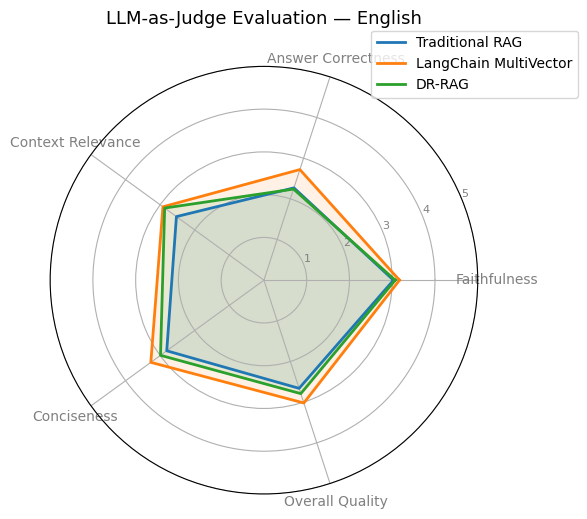

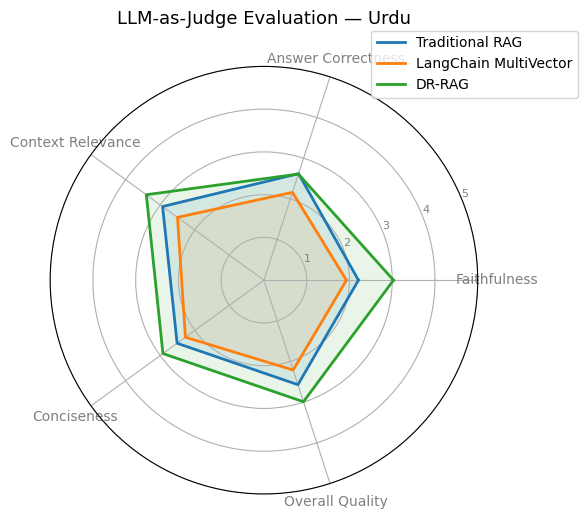

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
# ============================================
# English LLM-as-Judge Scores
# ============================================
criteria = ['Faithfulness', 'Answer Correctness', 'Context Relevance', 'Conciseness', 'Overall Quality']
N = len(criteria)

# Scores from paper
scores_en = {
    'Traditional RAG': [3.03, 2.27, 2.53, 2.81, 2.66],
    'LangChain MultiVector': [3.17, 2.72, 2.92, 3.27, 3.02],
    'DR-RAG': [3.07, 2.24, 2.87, 2.99, 2.79],
}

# Radar helper
def radar_plot(scores_dict, title):
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    plt.xticks(angles[:-1], criteria, color='grey', size=10)
    plt.yticks([1, 2, 3, 4, 5], color='grey', size=8)
    plt.ylim(0, 5)

    for label, scores in scores_dict.items():
        values = scores + [scores[0]]
        ax.plot(angles, values, linewidth=2, label=label)
        ax.fill(angles, values, alpha=0.1)
    
    plt.title(title, size=13, y=1.08)
    plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1.1))
    plt.tight_layout()
    plt.show()

# English Radar
radar_plot(scores_en, "LLM-as-Judge Evaluation — English")

# ============================================
# Urdu LLM-as-Judge Scores
# ============================================
scores_ur = {
    'Traditional RAG': [2.21, 2.62, 2.93, 2.51, 2.57],
    'LangChain MultiVector': [1.93, 2.16, 2.50, 2.27, 2.21],
    'DR-RAG': [3.03, 2.61, 3.40, 2.92, 2.99],
}

radar_plot(scores_ur, "LLM-as-Judge Evaluation — Urdu")
